# Data loader example

This is example code that demonstrates use of our custom data loader for the POCOVID-Net training data. Much of this code is based on snippets from the the official PyTorch tutorial on [custom datasets, dataloaders, and transforms](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). 

In [1]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import utils
from torchvision import transforms as tv_tsfm
import matplotlib.pyplot as plt

## Subclass `torch.utils.data.Dataset`

In [2]:
class PocovidDataset(Dataset):
  """Subclass of Dataset for POCOVID-Net data"""
  
  def __init__(self, root_dir, transform=None):
      """
      Args:
          root_dir (string): Directory with all the images.
          transform (callable, optional): Optional transform to be applied
              on a sample.
      """
      self.root_dir = root_dir
      self.transform = transform
      self.covid_dir = root_dir + '/' + 'covid'
      self.pneu_dir = root_dir + '/' + 'pneumonia'
      self.regular_dir = root_dir + '/' + 'regular'
      
      self.covid_class = 0
      self.pneu_class = 1
      self.regular_class = 2

      # Modified code snippet from Daniel Stutzbach: https://stackoverflow.com/a/2632251
      dir_items = lambda d: [d + "/" + name for name in os.listdir(d) if os.path.isfile(d + "/" + name)]

      covid_items = dir_items(self.covid_dir)
      pneu_items = dir_items(self.pneu_dir)
      regular_items = dir_items(self.regular_dir)
      
      num_covid = len(covid_items)
      num_pneu = len(pneu_items)
      num_regular = len(regular_items)
      
      self.img_info = []
      for covid_filename in covid_items:
        self.img_info.append((covid_filename,self.covid_class))
      for pneu_filename in pneu_items:
        self.img_info.append((pneu_filename,self.pneu_class))
      for regular_filename in regular_items:
        self.img_info.append((regular_filename,self.regular_class)) 

      self.transform = transform
      self.num_images = num_covid + num_pneu + num_regular
  
  def __len__(self):
    return self.num_images
  
  def __getitem__(self,idx):
    img_name, img_class = self.img_info[idx]
    image = Image.open(img_name)
    sample = {'image': image, 'class': img_class} 
    
    if self.transform:
      sample['image'] = self.transform(image)

    return sample

## Define transformations
These are the same or very similar to transformations defined in the official PyTorch tutorial on [custom datasets, dataloaders, and transforms](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [3]:
# TODO: Copy Rescale from the tutorial, and create a "rotate" tranform and a "translate" transform
# because the paper augments data in place by rotating up to 10 degrees, and translating up to 10 
# degrees

# Modified from official PyTorch tutorial: 
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms
# class Rescale(object):
#     """Rescale the image in a sample to a given size.

#     Args:
#         output_size (tuple or int): Desired output size. If tuple, output is
#             matched to output_size. If int, smaller of image edges is matched
#             to output_size keeping aspect ratio the same.
#     """

#     def __init__(self, output_size):
#         assert isinstance(output_size, (tuple))
#         self.output_size = output_size

#     def __call__(self, sample):
#         image, img_cls = sample['image'], sample['class']

#         # The authors do a "naive" resize to 224x224 and do not attempt to preserve aspect ratio,
#         # see line 88 of evaluate_covid19.py on the "arxiv" tag: 
#         # https://github.com/jannisborn/covid19_pocus_ultrasound/blob/arxiv/pocovidnet/pocovidnet/evaluate_covid19.py#L88
        
#         new_h, new_w = self.output_size
#         img = transform.resize(image, (new_h, new_w))

#         return {'image': img, 'class': img_cls}

# class RandomShift(object)
#   def __init__(self, shift_px):
#     assert isinstance(shift_px, int)
#     self.shift_px = shift_px
  
#   def __call__(self, sample):
#     image, img_cls = sample['image'], sample['class']
    
#     return {'image': shifted_image, 'landmarks': landmarks}

# class RandomRotation(object):
#     def __init__(self, max_deg):
#       self.max_deg = max_deg
      
#     def __call__(self, sample):
#       img, img_cls = sample['image'], sample['class']
#       rotated_img = tv_tsfm.functional.rotate(img,max_deg)
#       return {'image': rotated_img, 'class': img_cls}

# # From official PyTorch tutorial: 
# # https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms
# class ToTensor(object):
#     """Convert ndarrays in sample to Tensors."""

#     def __call__(self, sample):
#         image, img_cls = sample['image'], sample['class']

#         # swap color axis because
#         # numpy image: H x W x C
#         # torch image: C X H X W
#         image = image.transpose((2, 0, 1))
#         return {'image': torch.from_numpy(image),
#                 'class': img_cls}

## Create an instance of `PocovidDataset`, applying transformations "in place"

For the purposes of this example, I am assuming this notebook is being run from the `code/app` directory in this repository. If you use a different working directory, you will need to adjust the `root_dir` argument to the `PocovidDataset` constructor accordingly. 

In [4]:
os.getcwd() # show current working directory (for reference, not required for code below to work)

'/home/nathan/Code/covid19_pocus_ultrasound_pytorch/code/app'

In [5]:
transformed_dataset = PocovidDataset(root_dir='../data/pocus_images',
                                     transform=tv_tsfm.Compose([
                                       tv_tsfm.Resize((224,224)),
                                       tv_tsfm.RandomRotation(10),
                                       tv_tsfm.ToTensor()
                                       ]))

## Iterating through the dataset

### Option A: Using a `for` loop
First, let's iterate using a simple `for` loop. This works, but may not be as powerful / as efficient as using a `DataLoader` (see Option B).

In [6]:
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['class'])

    if i == 3:
        break

0 torch.Size([3, 224, 224]) 0
1 torch.Size([3, 224, 224]) 0
2 torch.Size([3, 224, 224]) 0
3 torch.Size([3, 224, 224]) 0


### Option B: Using `torch.utils.data.DataLoader`
**TODO:** get the commented code below to actually work.

In [7]:
dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=0)

In [8]:
# FIXME: 0, 1, and 2 are hardcoded both here and where we set self.covid_class, self.pneu_class, and 
# self.regular_class in the __init__ function for PocovidDataset
lbl_map = {0:"COVID",1:"Pneumonia",2:"Regular"} 

# based on show_landmarks_batch() in the official PyTorch dataloader tutorial
def show_labeled_images_batch(sample_batched):
  """Show image with class labels for a batch of samples."""
  images_batch, classes_batch = sample_batched['image'], sample_batched['class']
  batch_size = len(images_batch)
  assert images_batch.size(2) == images_batch.size(3)   # assume images are square
  im_width = images_batch.size(2) 
  grid_border_size = 2


  labels = [lbl_map[i.item()] for i in classes_batch]
  title_str = 'From left: ' + ', '.join(labels)
  plt.title(title_str)
  
  grid = utils.make_grid(images_batch)
  plt.imshow(grid.numpy().transpose((1, 2, 0)))
  plt.title(title_str)

In [9]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['class'])

    # observe 4th batch and stop.
    if i_batch == 3:
        break

0 torch.Size([4, 3, 224, 224]) tensor([2, 1, 0, 0])
1 torch.Size([4, 3, 224, 224]) tensor([0, 0, 1, 0])
2 torch.Size([4, 3, 224, 224]) tensor([0, 0, 0, 1])
3 torch.Size([4, 3, 224, 224]) tensor([0, 1, 1, 0])


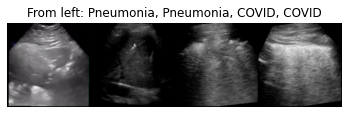

In [10]:
for i_batch, sample_batched in enumerate(dataloader):
    # observe 4th batch, visualize images, and stop
    if i_batch == 3:
        plt.figure()
        
        show_labeled_images_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break